In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import numpy as np
import re

### read data from the dataset file

In [2]:
df = pd.read_csv('imdb_master.csv', index_col=False, encoding='ISO-8859-1')
# Remove the first column
df = df.drop(df.columns[0], axis=1)
# Remove the rows with label == 'unsup'
df = df[df.label != 'unsup']

# create a overview of the 'label' and 'type' columns
print(df['label'].value_counts())
print(df['type'].value_counts())


neg    25000
pos    25000
Name: label, dtype: int64
test     25000
train    25000
Name: type, dtype: int64


In [3]:
df.head()

,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [4]:
# split the data into train and test by the type column
train_df = df[df.type == 'train']
test_df = df[df.type == 'test']

X_train = train_df['review']
y_train = train_df['label']

X_test = test_df['review']
y_test = test_df['label']

### text pre-processing

In [5]:
#Process the review column line by line to do text preprocessing
def process_review(review):
    # remove the punctuations and numbers
    review = re.sub(r'[^A-Za-z]+', ' ', review)
    # convert the review to lower case
    review = review.lower()
    # remove the stopwords
    stop_words = set(stopwords.words('english'))
    # tokenize the words
    word_tokens = word_tokenize(review)
    filtered_review = [w for w in word_tokens if not w in stop_words]
    # stem the words
    stemmer = PorterStemmer()
    stemmed_review = [stemmer.stem(w) for w in filtered_review]
    # # lemmatize the words
    # lemmatizer = WordNetLemmatizer()
    # lemmatized_review = [lemmatizer.lemmatize(w) for w in stemmed_review]
    # return the processed review
    return stemmed_review

In [6]:
# process the train and test reviews
X_train = X_train.apply(process_review)
X_test = X_test.apply(process_review)


In [7]:
X_train.head()

25000    [stori, man, unnatur, feel, pig, start, open, ...
25001    [airport, start, brand, new, luxuri, plane, lo...
25002    [film, lack, someth, put, finger, first, chari...
25003    [sorri, everyon, know, suppos, art, film, wow,...
25004    [littl, parent, took, along, theater, see, int...
Name: review, dtype: object

## Naïve Bayes classifier (baseline)

In [8]:
# create a vocabulary
vocab = {}
for review in X_train:
    for word in review:
        if word in vocab:
            vocab[word] += 1
        else:
            vocab[word] = 1

# sort the bag by the value
vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)
# remove the words with frequency less than 2
vocab = [x for x in vocab if x[1] >= 2]
# # add the <UNK> token
# vocab.append(('<UNK>', 0))
vocab[:10]


[('br', 101872),
 ('movi', 51717),
 ('film', 48210),
 ('one', 27749),
 ('like', 22806),
 ('time', 16198),
 ('good', 15367),
 ('make', 15212),
 ('charact', 14184),
 ('get', 14143)]

In [9]:
len(vocab)

30948

In [13]:
# create naive bayes model
def naive_bayes_model(X_train, y_train, vocab, k=1):
    # the key is the class and the value is the prior probability
    prior_prob = {}
    prior_prob['pos'] = y_train.value_counts()['pos'] / len(y_train)
    prior_prob['neg'] = y_train.value_counts()['neg'] / len(y_train)
    # the key is the class and the value is the conditional probability
    cond_prob = {}
    cond_prob['pos'] = {}
    cond_prob['neg'] = {}
    # calculate the conditional probability of each word given each class
    for word in vocab:
        # calculate the conditional probability of the word given the class 'pos'
        word_given_pos = X_train[y_train == 'pos'].apply(lambda x: x.count(word[0]))
        cond_prob['pos'][word[0]] = (word_given_pos.sum() + k) / (len(X_train[y_train == 'pos']) + k * len(vocab))
        # calculate the conditional probability of the word given the class 'neg'
        word_given_neg = X_train[y_train == 'neg'].apply(lambda x: x.count(word[0]))
        cond_prob['neg'][word[0]] = (word_given_neg.sum() + k) / (len(X_train[y_train == 'neg']) + k * len(vocab))

    return prior_prob, cond_prob
              

In [14]:
prior_prob, cond_prob = naive_bayes_model(X_train, y_train, vocab, k=1)

In [16]:
cond_prob['pos']['best']

0.09954428282084331

In [17]:
# predict the class of the test dataset
def get_y_pred(X_test, prior_prob, cond_prob, vocab):
    y_pred = []
    for review in X_test:
        # calculate the posterior probability of each class given the review
        pos_prob = np.log(prior_prob['pos'])
        neg_prob = np.log(prior_prob['neg'])
        for word in review:
            # if the word appear in the 'pos' class
            if word in cond_prob['pos']:
                pos_prob += np.log(cond_prob['pos'][word])
            if word in cond_prob['neg']:
                neg_prob += np.log(cond_prob['neg'][word]) 
        # predict the class of the review
        if pos_prob > neg_prob:
            y_pred.append('pos')
        else:
            y_pred.append('neg')
    return y_pred


In [18]:
y_pred = get_y_pred(X_test, prior_prob, cond_prob, vocab)

In [19]:
# calculate the accuracy of the model on the test dataset from the predicted class
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.82464

### F1 measure

In [20]:
# calculate the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,neg,pos
Actual,,
neg,9929,2571
pos,1813,10687


In [47]:
# build F1 score method
def f1_score(y_true, y_pred):
    # get the true positive, false positive, false negative
    tp = ((y_true == 'pos') & (y_pred == 'pos')).sum()
    fp = ((y_true == 'neg') & (y_pred == 'pos')).sum()
    fn = ((y_true == 'pos') & (y_pred == 'neg')).sum()
    # calculate the precision and recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    # calculate the F1 score
    f1 = 2 * precision * recall / (precision + recall)
    return f1

In [24]:
# convert the class to a numpy array
y_pred0 = np.array(y_pred)
y_test0 = np.array(y_test)

f1 = f1_score(y_test0, y_pred0)
f1


0.8298004503455236

## Experiment

### K-smoothing

In [48]:
import time

# try different values of k on the naive bayes model
for k in [0, 5, 10, 15, 20]:
    start_time = time.time()
    prior_prob, cond_prob = naive_bayes_model(X_train, y_train, vocab, k=k)
    y_pred = get_y_pred(X_test, prior_prob, cond_prob, vocab)
    
    accuracy = (y_pred == y_test).sum() / len(y_test)
    print('k = {}, accuracy = {}, time taken = {:.2f} seconds'.format(k, accuracy, time.time() - start_time))
    y_pred0 = np.array(y_pred)
    y_test0 = np.array(y_test)
    f1 = f1_score(y_test0, y_pred0)
    print('k = {}, F1 score = {}, time taken = {:.2f} seconds'.format(k, f1, time.time() - start_time))


/var/folders/tr/3_k_czmn2552n9rftmys1pwh0000gn/T/ipykernel_12770/2548843458.py:13: RuntimeWarning: divide by zero encountered in log
  neg_prob += np.log(cond_prob['neg'][word])
/var/folders/tr/3_k_czmn2552n9rftmys1pwh0000gn/T/ipykernel_12770/2548843458.py:11: RuntimeWarning: divide by zero encountered in log
  pos_prob += np.log(cond_prob['pos'][word])


k = 0, accuracy = 0.73472, time taken = 1144.84 seconds
k = 0, F1 score = 0.7212274064733082, time taken = 1144.85 seconds
k = 5, accuracy = 0.82896, time taken = 1746.18 seconds
k = 5, F1 score = 0.8347758887171561, time taken = 1746.18 seconds
k = 10, accuracy = 0.83028, time taken = 1174.87 seconds
k = 10, F1 score = 0.8359559249951671, time taken = 1174.88 seconds
k = 15, accuracy = 0.83188, time taken = 1133.71 seconds
k = 15, F1 score = 0.8374269910648667, time taken = 1133.71 seconds
k = 20, accuracy = 0.83304, time taken = 1131.71 seconds
k = 20, F1 score = 0.8383173225906415, time taken = 1131.72 seconds


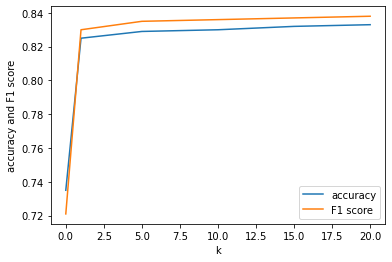

In [61]:
from matplotlib import pyplot as plt
# plot the accuracy and F1 score of the naive bayes model with different values of k
k_values = [0, 1, 5, 10, 15, 20]
accuracy_values = [0.735, 0.825, 0.829, 0.830, 0.832, 0.833]
f1_values = [0.721, 0.830, 0.835, 0.836, 0.837, 0.838]
# plot the accuracy and F1 score
plt.plot(k_values, accuracy_values, label='accuracy')
plt.plot(k_values, f1_values, label='F1 score')
plt.xlabel('k')
plt.ylabel('accuracy and F1 score')
plt.legend()
plt.show()
